In [1]:
#importing libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing modules:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder

#Model:
from sklearn.ensemble import RandomForestClassifier
#Metrics:
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve
#saving the model:
import pickle

In [2]:
data = pd.read_csv('shipping_data.csv')

In [3]:
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [4]:
df = data.copy()

In [5]:
df.shape

(10999, 12)

In [6]:
#information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [7]:
#checking the missing values:
df.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

### Mapping the values in the Warehouse_block feature for convenience

In [8]:
# Changing the 'F' values into 'E'
df['Warehouse_block'].unique()

array(['D', 'F', 'A', 'B', 'C'], dtype=object)

In [9]:
whb_map = {
    'A':'A',
    'B':'B',
    'C':'C',
    'D':'D',
    'F':'E',
}

In [10]:
df['Warehouse_block'] = df['Warehouse_block'].map(whb_map)

In [11]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,E,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [12]:
# Successfully mapped 'E' with 'F'
df['Warehouse_block'].unique()

array(['D', 'E', 'A', 'B', 'C'], dtype=object)

### Correlation Heatmap

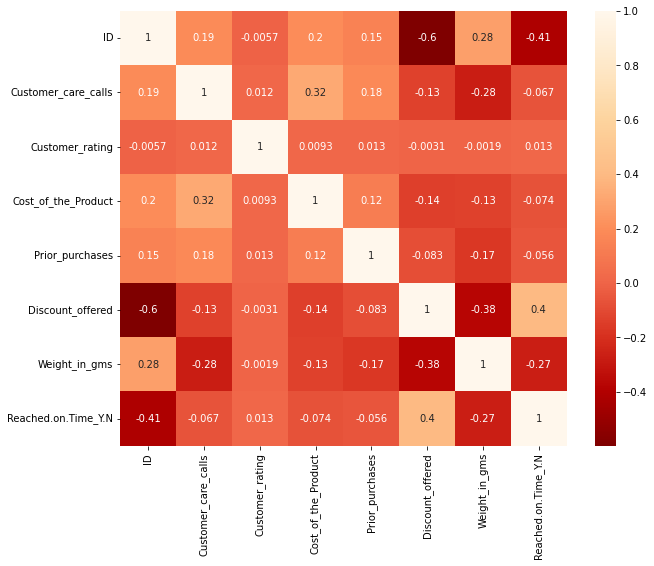

In [13]:
corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='OrRd_r')
plt.show()

#### There isn't enough correlation among the input features in order to drop any
## Dropping the uniquely identifying feature : ID

In [14]:
df.drop(['ID'], axis=1, inplace=True)

### Train-Test Split

In [15]:
X = df.drop(['Reached.on.Time_Y.N'], axis=1)

In [16]:
X.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,D,Flight,4,2,177,3,low,F,44,1233
1,E,Flight,4,5,216,2,low,M,59,3088
2,A,Flight,2,2,183,4,low,M,48,3374
3,B,Flight,3,3,176,4,medium,M,10,1177
4,C,Flight,2,2,184,3,medium,F,46,2484


In [17]:
y = df['Reached.on.Time_Y.N']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Reached.on.Time_Y.N, dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Preprocessing
### Preprocessing the Train & Test Data separately to avoid Data Leakage
#### 1. Handling Continuous Features (Checking for the outliers)

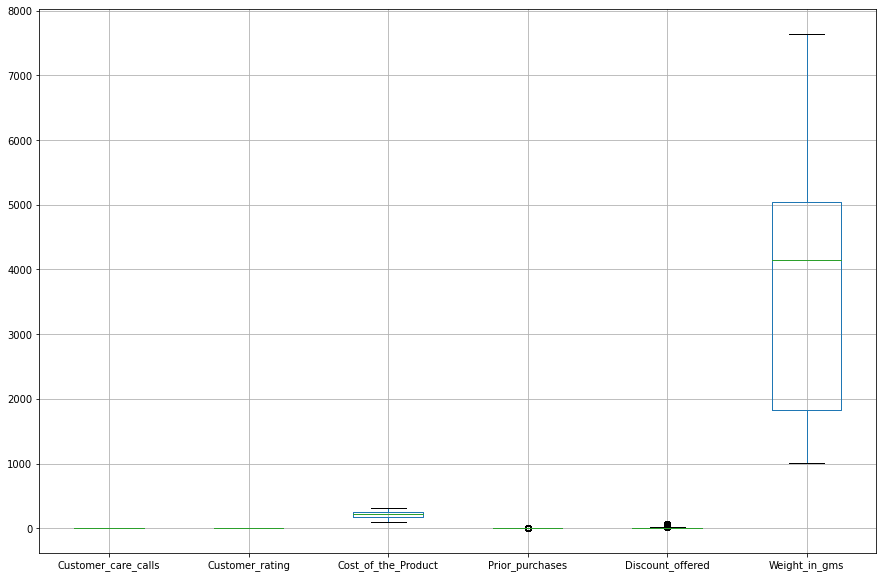

In [19]:
plt.figure(figsize=(15, 10))

X_train.boxplot()
plt.show()

### Features with outliers
#### 1. Prior_purchases

#### 2. Discount_offered

In [20]:
outliers_features = ['Discount_offered', 'Prior_purchases']
outliers_features

['Discount_offered', 'Prior_purchases']

### Creating a custom Transformer to handle the Outliers

In [21]:
from sklearn.base import TransformerMixin
import pandas as pd
pd.options.mode.chained_assignment = None  # To ignore the warning for not returning a copied DataFrame

class HandleOutliers(TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        from scipy.stats import shapiro

        for col in X.columns : # Looping through all columns within the given DataFrame
            
            # If p-value < 0.05 == Skewed Distribution, else Normal Distribution
            
            if shapiro(X[col]).pvalue < 0.05 :

                # IQR method to handle outliers with Skewed Distribution
                q1 = X[col].quantile(0.25)
                q3 = X[col].quantile(0.75)

                iqr = q3 - q1

                lower_boundary = q1 - 1.5 * q1
                upper_boundary = q3 + 1.5 * q3

                X.loc[X[col] <= lower_boundary, col] = lower_boundary
                X.loc[X[col] >= upper_boundary, col] = upper_boundary

                
            else :

                # 3-Sigma method to handle outliers with Normal Distribution
                lower_boundary = X[col].mean() - 3 * X[col].std()
                upper_boundary = X[col].mean() + 3 * X[col].std()

                X.loc[X[col] <= lower_boundary, col] = lower_boundary
                X.loc[X[col] >= upper_boundary, col] = upper_boundary
        return X          


In [22]:
outliers = HandleOutliers()

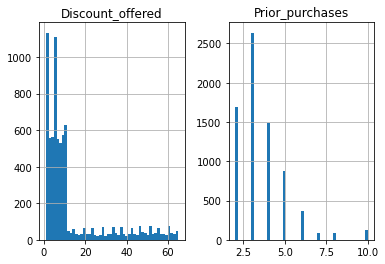

In [23]:
# X_train before handling the outliers
X_train[outliers_features].hist(bins=50)
plt.show()

In [24]:
outliers_df = outliers.fit_transform(X_train[outliers_features])

C:\Users\91844\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


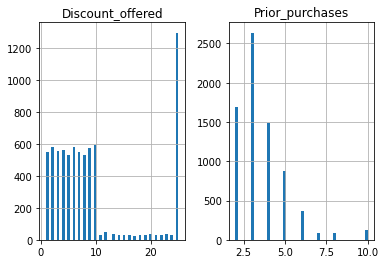

In [25]:
outliers_df.hist(bins=50)
plt.show()

In [26]:
X_train.drop(outliers_features, axis=1, inplace=True)

In [27]:
X_train = pd.concat([X_train, outliers_df], axis=1)

In [28]:
X_train.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Product_importance,Gender,Weight_in_gms,Discount_offered,Prior_purchases
2400,D,Ship,2,5,171,medium,F,1101,13,3.0
5559,B,Ship,4,1,144,medium,M,5197,6,4.0
1143,B,Ship,3,3,224,low,F,3220,25,2.0
7699,E,Ship,2,1,149,medium,F,5434,7,4.0
5731,E,Road,3,4,191,medium,F,4243,4,5.0


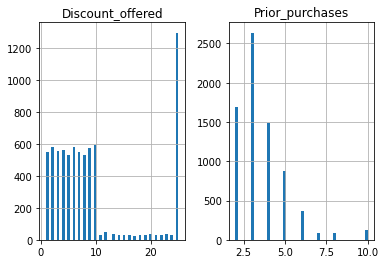

In [29]:
# X_train after handling the outliers
X_train[outliers_features].hist(bins=50)
plt.show()

### 2. Handling Categorical Features (Encoding)

In [30]:
# Appending all the features with dtype == 'object' (Categorical Features) in a list
cat_features = []

for col in X_train.columns :
    if X_train[col].dtype == 'object' :
        cat_features.append(col)
        
cat_features

['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

### Nomial Features ( Using One Hot Encoding)
#### 1. Warehouse_block
#### 2. Mode_of_Shipment
#### 3. Gender

###### Ordinal Features ( Using Map Method)
1. Product_importance

In [31]:
dummies_WH_block = pd.get_dummies(X_train['Warehouse_block'], prefix = 'WH_Block', drop_first = True)
dummies_Mode_of_S = pd.get_dummies(X_train['Mode_of_Shipment'], prefix= 'Mode_of_S', drop_first = True)
dummies_Gender = pd.get_dummies(X_train['Gender'], prefix= 'Gender', drop_first = True)

In [32]:
encode_df = pd.concat([dummies_WH_block, dummies_Mode_of_S, dummies_Gender], axis=1)
encode_df.head()

,WH_Block_B,WH_Block_C,WH_Block_D,WH_Block_E,Mode_of_S_Road,Mode_of_S_Ship,Gender_M
2400,0,0,1,0,0,1,0
5559,1,0,0,0,0,1,1
1143,1,0,0,0,0,1,0
7699,0,0,0,1,0,1,0
5731,0,0,0,1,1,0,0


In [33]:
X_train = pd.concat([X_train, encode_df], axis=1)

In [34]:
X_train.head()


,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Product_importance,Gender,Weight_in_gms,Discount_offered,Prior_purchases,WH_Block_B,WH_Block_C,WH_Block_D,WH_Block_E,Mode_of_S_Road,Mode_of_S_Ship,Gender_M
2400,D,Ship,2,5,171,medium,F,1101,13,3.0,0,0,1,0,0,1,0
5559,B,Ship,4,1,144,medium,M,5197,6,4.0,1,0,0,0,0,1,1
1143,B,Ship,3,3,224,low,F,3220,25,2.0,1,0,0,0,0,1,0
7699,E,Ship,2,1,149,medium,F,5434,7,4.0,0,0,0,1,0,1,0
5731,E,Road,3,4,191,medium,F,4243,4,5.0,0,0,0,1,1,0,0


In [35]:
X_train.drop(['Warehouse_block', 'Mode_of_Shipment', 'Gender' ], axis=1, inplace=True)
X_train.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Product_importance,Weight_in_gms,Discount_offered,Prior_purchases,WH_Block_B,WH_Block_C,WH_Block_D,WH_Block_E,Mode_of_S_Road,Mode_of_S_Ship,Gender_M
2400,2,5,171,medium,1101,13,3.0,0,0,1,0,0,1,0
5559,4,1,144,medium,5197,6,4.0,1,0,0,0,0,1,1
1143,3,3,224,low,3220,25,2.0,1,0,0,0,0,1,0
7699,2,1,149,medium,5434,7,4.0,0,0,0,1,0,1,0
5731,3,4,191,medium,4243,4,5.0,0,0,0,1,1,0,0


In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7369 entries, 2400 to 7270
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_care_calls  7369 non-null   int64  
 1   Customer_rating      7369 non-null   int64  
 2   Cost_of_the_Product  7369 non-null   int64  
 3   Product_importance   7369 non-null   object 
 4   Weight_in_gms        7369 non-null   int64  
 5   Discount_offered     7369 non-null   int64  
 6   Prior_purchases      7369 non-null   float64
 7   WH_Block_B           7369 non-null   uint8  
 8   WH_Block_C           7369 non-null   uint8  
 9   WH_Block_D           7369 non-null   uint8  
 10  WH_Block_E           7369 non-null   uint8  
 11  Mode_of_S_Road       7369 non-null   uint8  
 12  Mode_of_S_Ship       7369 non-null   uint8  
 13  Gender_M             7369 non-null   uint8  
dtypes: float64(1), int64(5), object(1), uint8(7)
memory usage: 510.9+ KB


###### Ordinal Encoding for the ordinal feature (Using Mapping)

In [37]:
X_train['Product_importance'].unique()

array(['medium', 'low', 'high'], dtype=object)

In [38]:
Product_imp = {
    'low' : 0,
    'medium' : 1,
    'high' : 2

}

In [39]:
X_train['Product_Importance'] = X_train['Product_importance'].map(Product_imp)
X_train.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Product_importance,Weight_in_gms,Discount_offered,Prior_purchases,WH_Block_B,WH_Block_C,WH_Block_D,WH_Block_E,Mode_of_S_Road,Mode_of_S_Ship,Gender_M,Product_Importance
2400,2,5,171,medium,1101,13,3.0,0,0,1,0,0,1,0,1
5559,4,1,144,medium,5197,6,4.0,1,0,0,0,0,1,1,1
1143,3,3,224,low,3220,25,2.0,1,0,0,0,0,1,0,0
7699,2,1,149,medium,5434,7,4.0,0,0,0,1,0,1,0,1
5731,3,4,191,medium,4243,4,5.0,0,0,0,1,1,0,0,1


In [40]:
X_train['Product_Importance'].unique()

array([1, 0, 2], dtype=int64)

In [41]:
X_train.drop(['Product_importance'], axis=1, inplace=True)

In [42]:
# New X_train with Ordinal values of the feature 'Product_Importance'
X_train.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Weight_in_gms,Discount_offered,Prior_purchases,WH_Block_B,WH_Block_C,WH_Block_D,WH_Block_E,Mode_of_S_Road,Mode_of_S_Ship,Gender_M,Product_Importance
2400,2,5,171,1101,13,3.0,0,0,1,0,0,1,0,1
5559,4,1,144,5197,6,4.0,1,0,0,0,0,1,1,1
1143,3,3,224,3220,25,2.0,1,0,0,0,0,1,0,0
7699,2,1,149,5434,7,4.0,0,0,0,1,0,1,0,1
5731,3,4,191,4243,4,5.0,0,0,0,1,1,0,0,1


##### Preprocessing the test data seperately:

In [43]:
# 1. Handling the outliers (Using transform method for Test data)
outliers_df = outliers.transform(X_test[outliers_features])

X_test.drop(outliers_features, axis=1, inplace=True)

X_test = pd.concat([X_test, outliers_df], axis=1)

# 2. OneHotEncoding

dummies_WH_Block = pd.get_dummies(X_test['Warehouse_block'], prefix='WH_Block', drop_first=True)
dummies_Mode_of_S = pd.get_dummies(X_test['Mode_of_Shipment'], prefix='Mode_of_S', drop_first=True)
dummies_Gender = pd.get_dummies(X_test['Gender'], prefix='Gender', drop_first=True)

encode_df = pd.concat([dummies_WH_Block, dummies_Mode_of_S, dummies_Gender], axis=1)

X_test = pd.concat([X_test, encode_df], axis=1)

X_test.drop(['Warehouse_block', 'Mode_of_Shipment', 'Gender'], axis=1, inplace=True)

# 3. Ordinal Encoding (using map method)
X_test['Product_Importance'] = X_test['Product_importance'].map(Product_imp)

X_test.drop(['Product_importance'], axis=1, inplace=True)

In [44]:
X_test.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Weight_in_gms,Discount_offered,Prior_purchases,WH_Block_B,WH_Block_C,WH_Block_D,WH_Block_E,Mode_of_S_Road,Mode_of_S_Ship,Gender_M,Product_Importance
107,4,5,216,2053,25,3,0,0,0,1,0,1,1,2
5594,3,1,220,5572,6,3,0,0,0,0,1,0,0,0
6997,3,2,215,4042,3,4,0,0,0,1,0,0,0,0
3984,5,1,160,4672,1,5,0,0,1,0,0,0,0,0
3111,5,4,229,2419,25,2,1,0,0,0,0,1,0,1


#### Model Building:

In [45]:
rf = RandomForestClassifier()

In [46]:
rf_model = rf.fit(X_train, y_train)

In [47]:
rf_model.score(X_test, y_test)

0.6603305785123967

#### Hyperparameter Tuning:

In [48]:
rf_params = {
    'n_estimators' : [50,100,130,150],
    'max_depth' : [4,5,10,20, None],
    'min_samples_split' : [2,3,4,5],
    'min_samples_leaf' : [1,4,10,20],
    'max_leaf_nodes' : [2,5,10, None]
}

In [49]:
rf_rs = RandomizedSearchCV(rf, rf_params, cv = 5, n_iter=10)

In [50]:
rf_best_model = rf_rs.fit(X_train, y_train)

In [51]:
rf_best_model.score(X_test, y_test)

0.6793388429752066

In [52]:
rf_best_model.best_params_

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'max_leaf_nodes': None,
 'max_depth': 20}

In [53]:
rf_best_model.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=150)

#### Model Performance:

In [54]:
y_pred = rf_best_model.predict(X_test)

In [55]:
import warnings
warnings.filterwarnings('ignore')

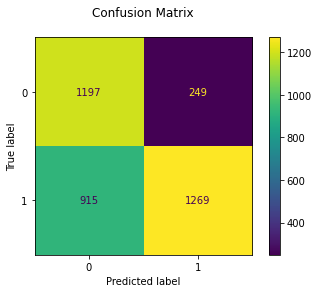

In [56]:
plot_confusion_matrix(rf_best_model, X_test, y_test)
plt.title('Confusion Matrix\n')
plt.show()

In [57]:
print("Classification Report:\n\n", classification_report(y_test, y_pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.57      0.83      0.67      1446
           1       0.84      0.58      0.69      2184

    accuracy                           0.68      3630
   macro avg       0.70      0.70      0.68      3630
weighted avg       0.73      0.68      0.68      3630



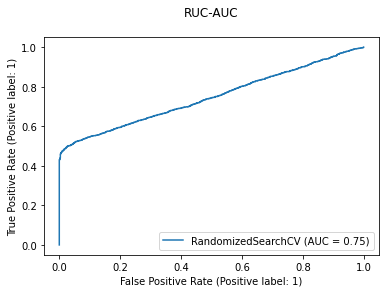

In [58]:
plot_roc_curve(rf_best_model, X_test, y_test)
plt.title('RUC-AUC\n')
plt.show()

#### Saving(Dumping) the model:

In [59]:
#open a file where you want to store the data

file = open ('e_commerce_rf.pkl', 'wb')

#dump information to that file
pickle.dump(rf_best_model, file)

In [60]:
model = open('e_commerce_rf.pkl', 'rb')

#### Predictions:

In [61]:
test_data = X_test.head()
test_data

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Weight_in_gms,Discount_offered,Prior_purchases,WH_Block_B,WH_Block_C,WH_Block_D,WH_Block_E,Mode_of_S_Road,Mode_of_S_Ship,Gender_M,Product_Importance
107,4,5,216,2053,25,3,0,0,0,1,0,1,1,2
5594,3,1,220,5572,6,3,0,0,0,0,1,0,0,0
6997,3,2,215,4042,3,4,0,0,0,1,0,0,0,0
3984,5,1,160,4672,1,5,0,0,1,0,0,0,0,0
3111,5,4,229,2419,25,2,1,0,0,0,0,1,0,1


In [62]:
y_test.head()

107     1
5594    1
6997    0
3984    0
3111    1
Name: Reached.on.Time_Y.N, dtype: int64

In [63]:
rf_best_model.predict(test_data)

array([1, 0, 1, 0, 1], dtype=int64)

In [64]:
rf_best_model.predict([[4, 5, 216, 2053, 25.0, 3.0, 0, 0, 0, 1, 0, 1, 1, 2]])

array([1], dtype=int64)